# Getting historical SELIC interest rate from brazilian Central Bank API 

**What ?** The SELIC rate (Sistema Especial de Liquidação e de Custódia) is the Brazilian Central Bank's benchmark interest rate. It is used as the primary tool for controlling inflation and is the interest rate at which banks lend to each other overnight. The SELIC rate influences all other interest rates in the economy, including those for loans, savings, and investments. It is set by the Central Bank's Monetary Policy Committee (COPOM) and is an important indicator of the Brazilian economy's monetary policy stance.

**Why ?** Risk-free interest rate is a crucial element in financial market analysis as it serves as a benchmark for evaluating investment opportunities. This rate represents the return on an investment with zero risk of financial loss. By knowing the risk-free rate, it is possible to compare the potential returns of various investments against this baseline. oreover, the risk-free rate is integral to models like the Capital Asset Pricing Model (CAPM), which calculates the expected return on an asset based on its risk relative to the market. 

**How ?** The last 20 years of SELIC daily values will be downloaded from the Brazilian Central Bank API using requests librarys [link here](https://dadosabertos.bcb.gov.br/dataset/11-taxa-de-juros---selic). Data cleaning and transformations will be applied, and finally, the dataframe will be uploaded to a local SQLite database.


<img src="https://lh3.googleusercontent.com/d/1XXGD-325RPwPcIyBCBvHqe9s3dA6-n0i" alt="texto_alternativo" width="300" align="center">

### Import Libraries

In [163]:
import pandas as pd
import numpy as np
import os

import sqlite3
import requests
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

### Getting Data

#### Setting the time window to download the data 

In [177]:
amount_years = 23 # Manual parameter to set a custom date window 

today = date.today()
#init = datetime.now() + timedelta(days=(-365.25*amount_years)) # Uncomment to set 'amount_years' years ago.
init = datetime.strptime('02/01/2001', '%d/%m/%Y')

print("Start Date: ", init.strftime("%d/%m/%Y"), '\n' "End Date: ", today.strftime("%d/%m/%Y"))

Start Date:  02/01/2001 
End Date:  12/06/2024


#### Requesting data to Brazilian Central Bank API

In [178]:
# url to brazilian Central Bank risk free historical series (setting above initial and final date defined as parameter)
url_selic = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial="+init.strftime("%d/%m/%Y")+"&dataFinal="+today.strftime("%d/%m/%Y")

response = requests.get(url_selic)

if response.status_code == 200:
    df_selic_bc = pd.DataFrame(response.json())
else:
    print('Connection erro: {}'.format(response.status_code))
    
df_selic_bc.head()

,data,valor
0,02/01/2001,0.058400
1,03/01/2001,0.058195
2,04/01/2001,0.058332
3,05/01/2001,0.058229
4,08/01/2001,0.058229


#### Ajusting dataframe formats

In [179]:
#changing datetime format
df_selic_bc['ReferenceDate'] = pd.to_datetime(df_selic_bc['data'], format='%d/%m/%Y')
df_selic_bc.drop(columns = 'data', inplace = True)

df_selic_bc['Year-Month'] = df_selic_bc['ReferenceDate'].dt.year.astype(str) + '-'+ df_selic_bc['ReferenceDate'].dt.month.astype(str)
df_selic_bc['Year'] = df_selic_bc['ReferenceDate'].dt.year.astype(str)

#calculating SELIC index rate in a % of year base
df_selic_bc.rename(columns = {'valor':'SELIC_DAY'},inplace =True)
df_selic_bc['SELIC_DAY'] = df_selic_bc['SELIC_DAY'].astype(float) #SELIC expressed % day
df_selic_bc['SELIC_YEAR'] = ((((df_selic_bc['SELIC_DAY']/100)+1)**252)-1) #SELIC expressed % year

#changing columns ordering
df_selic_bc = df_selic_bc[['ReferenceDate','Year-Month','Year','SELIC_DAY','SELIC_YEAR']]
df_selic_bc

,ReferenceDate,Year-Month,Year,SELIC_DAY,SELIC_YEAR
0,2001-01-02,2001-1,2001,0.058400,0.158499
1,2001-01-03,2001-1,2001,0.058195,0.157901
2,2001-01-04,2001-1,2001,0.058332,0.158300
3,2001-01-05,2001-1,2001,0.058229,0.158000
4,2001-01-08,2001-1,2001,0.058229,0.158000
...,...,...,...,...,...
5882,2024-06-05,2024-6,2024,0.039270,0.104001
5883,2024-06-06,2024-6,2024,0.039270,0.104001
5884,2024-06-07,2024-6,2024,0.039270,0.104001
5885,2024-06-10,2024-6,2024,0.039270,0.104001


#### Plot graphic of SELIC per year

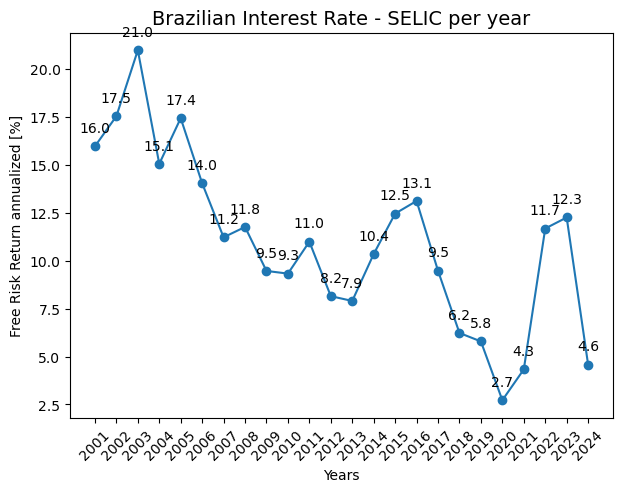

In [180]:
# calculating accumulated SELIC per year
df_selic_bc_year = df_selic_bc.groupby('Year')['SELIC_DAY'].sum().reset_index()

fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(df_selic_bc_year['Year'], df_selic_bc_year['SELIC_DAY'], marker='o')

# Adding tick labels at each point
for i, txt in enumerate(df_selic_bc_year['SELIC_DAY']):
    ax.annotate(f'{txt:.1f}', (df_selic_bc_year['Year'][i], df_selic_bc_year['SELIC_DAY'][i]),
                textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks(rotation=45)

ax.set_title('Brazilian Interest Rate - SELIC per year', fontsize=14)
ax.set_xlabel('Years')
ax.set_ylabel('Free Risk Return annualized [%]')

plt.show()

#### Upload dataframe into a local SQLIte

In [181]:
# write the dataframe into the SQLite database
conn = sqlite3.connect('D:/finance_data/finance_database.db')

df_selic_bc.to_sql('BACEN_risk_free_rate',conn,if_exists='replace',index=False)

5887